#**<center>Natural Language Text to SQL Query Conversion**

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
pip install records

     |████████████████████████████████| 163kB 6.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for openpyxl: filename=openpyxl-2.4.11-py2.py3-none-any.whl size=222821 sha256=30f281cd0beabd757c64903de7d3f67f70a009f5b83d80b64c2340c03c89093e
  Stored in directory: /root/.cache/pip/wheels/59/44/27/63b211425501ad51d197ff8ed00e9e469e38b9e516cb69b1c2
Successfully built openpyxl
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [4]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import records
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import json
import time
import unicodedata
from nltk.tokenize import word_tokenize

from __future__ import unicode_literals, print_function, division

from collections import defaultdict
from io import open
from __future__ import unicode_literals, print_function, division

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from torch.autograd import Variable
from torch import optim
from torchsummary import summary

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import os
import sys
sys.path.append('/content/drive/MyDrive/lib/')

In [8]:
from lib_db import *

###**Creating Required directories**

In [9]:
"""functions for directory creation"""
def dir_exists(directory):
    """
    Checks if 'directory' exists
    """
    return(os.path.isdir(directory))

def create_dir(directory):
    """
    Create directory
    """
    if not dir_exists(directory):
        os.mkdir(directory)
        print("Directory %s created successfully." %directory)
    else:
        print("Directory %s exists." %directory)

print("We are in:",os.getcwd())

"""
Required directory creation
"""
project_dir="/content/drive/MyDrive/Data606_finalproject"
create_dir(project_dir)


project_data_dir = project_dir + "/data/"
create_dir(project_data_dir)

project_result_dir = project_dir + "/output/"
create_dir(project_result_dir)

project_checkpoint_dir = project_dir + "/project_Checkpoint/"
create_dir(project_checkpoint_dir)

print(project_data_dir)

We are in: /content
Directory /content/drive/MyDrive/Data606_finalproject exists.
Directory /content/drive/MyDrive/Data606_finalproject/data/ exists.
Directory /content/drive/MyDrive/Data606_finalproject/output/ exists.
Directory /content/drive/MyDrive/Data606_finalproject/project_Checkpoint/ exists.
/content/drive/MyDrive/Data606_finalproject/data/


###**Listing files in Directories**

In [10]:
def list_dir(dir_path):
  """
  List directories for a given path
  """
  print("Directory %s contains : " %dir_path)
  for dir_or_file in os.listdir(dir_path):
    print(dir_or_file)
  print("\n")

"""
List created directories
"""
print('Current directory : ', os.getcwd(),'\n')
list_dir(project_dir)
list_dir(project_data_dir)
list_dir(project_checkpoint_dir)

Current directory :  /content 

Directory /content/drive/MyDrive/Data606_finalproject contains : 
data
output
project_Checkpoint
saved_model
Data606_Project_preprocess.ipynb


Directory /content/drive/MyDrive/Data606_finalproject/data/ contains : 
test.tables.jsonl
dev.tables.jsonl
train.tables.jsonl
dev.db
train.db
test.db
train.jsonl
dev.jsonl
test.jsonl
glove.6B.300d.txt
glove.6B.100d.txt


Directory /content/drive/MyDrive/Data606_finalproject/project_Checkpoint/ contains : 




In [11]:
train_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/train.jsonl', lines=True )

train_data.head()

,phase,table_id,question,sql
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']..."
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ..."
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']..."
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita..."
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}"


In [12]:
len(train_data)

56355

In [13]:
dev_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/dev.jsonl', lines=True )
len(dev_data)

8421

In [14]:
test_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/test.jsonl', lines=True )
len(test_data)

15878

In [15]:
train_tables_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/train.tables.jsonl', lines=True )

train_tables_data.head()

,id,header,types,rows,name,page_title,section_title,caption,page_id
0,1-1000181-1,"[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",table_1000181_1,NaN,NaN,NaN,NaN
1,1-10006830-1,"[Aircraft, Description, Max Gross Weight, Tota...","[text, text, text, text, text]","[[Robinson R-22, Light utility helicopter, 1,3...",table_10006830_1,Disk loading,Examples,Disk loading comparison,NaN
2,1-10007452-3,"[Order Year, Manufacturer, Model, Fleet Series...","[text, text, text, text, text, text]","[[1992-93, Gillig, Phantom (High Floor), 444-4...",table_10007452_3,Torrance Transit,Fleet,Fleet,NaN
3,1-10015132-1,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Quincy Acy, 4, United States, Forward, 2012-...",table_10015132_1,Toronto Raptors all-time roster,A,A,NaN
4,1-10015132-14,"[Player, No., Nationality, Position, Years in ...","[text, real, text, text, text, text]","[[Patrick O'Bryant, 13, United States, Center,...",table_10015132_14,Toronto Raptors all-time roster,O,O,NaN


###**Text Preprocessing**

In [24]:
class textconversion:
    """Class is responsible for converting all the sql structured output to plain text sql queries"""

    def __init__(self):
        self.table_map = {}  # key is table_id, value is all the table data

    def build_table_mapping(self, dataset):
        """Reads the tables file and creates a dictionary with table id as key and all other data as value"""
        tables = pd.read_json("/content/drive/MyDrive/Data606_finalproject/data/" + dataset + ".tables.jsonl", lines=True)
        data = pd.DataFrame()
        for index, line in tables.iterrows():  
            self.table_map[line["id"]] = line
            line["tokenized_header"] = []
            for column_header in line["header"]:
                line["tokenized_header"].append(self.tokenize_document(column_header))
            line_df = pd.DataFrame(line)
            line_df = line_df.transpose()
            data = data.append(line_df)
        self.save_dataframe(data, "/content/drive/MyDrive/Data606_finalproject/output/tokenized_" + dataset + ".tables.jsonl")

    def get_query_from_json(self, json_line):
        """Returns a Query object and table object for the json input"""
        q = Query.from_dict(json_line["sql"])
        t_id = json_line["table_id"]
        table = self.table_map[t_id]
        t = Table("", table["header"], table["types"], table["rows"])
        return t, q

    @staticmethod
    def execute_query(table, query):
        """Executes a query on the sqlite training database for testing"""
        db = records.Database('sqlite:///../data/train.db')
        conn = db.get_connection()
        query, result = table.execute_query(conn, query)
        conn.close()
        print(query, result)

    @staticmethod
    def tokenize_document(doc, print_token = False):
        operators = {'=' : 'EQL', '>' : 'GT', '<' : 'LT'}
        syntax_tokens = ["SELECT", "COUNT", "WHERE", "AND", "OR", "FROM"]
        tokens = nltk.word_tokenize(doc)
        for i in range(len(tokens)):
            if tokens[i] in syntax_tokens:
                continue
            if tokens[i] in operators.keys():
                tokens[i] = operators[tokens[i]]
            else:
                tokens[i] = tokens[i].lower()
        return tokens

    @staticmethod
    def save_dataframe(data, filename):
        data.to_json(filename, orient='records', lines=True)


    def build_tokenized_dataset(self, dataset):
        """Reads the input training files and generates a new file containing plain text sql queries"""
        self.build_table_mapping(dataset) #creates a dictionary with table id as key and all other data as value
        
        queries = pd.read_json("/content/drive/MyDrive/Data606_finalproject/data/" + dataset + ".jsonl", lines=True)

        count = 0
        stop_limit = len(queries)
        data = pd.DataFrame()

        # stop_limit = 10
        # iterate over the queries and convert each one to plain text sql
        for index, line in queries.iterrows(): 
            count += 1
            # get table and query representations
            table, query = self.get_query_from_json(line)
            
            # append query to dict, to add it to the datafram
            query_str = table.query_str(query)

            # Tokenize the query
            tokenized_query = self.tokenize_document(query_str, print_token = True)
            line["tokenized_query"] = tokenized_query
            
            # Fix the formatting of the query (lowercase + Uppercase syntax tokens)
            line["query"] = " ".join(tokenized_query)
            
            # Tokenize the question
            tokenized_question = self.tokenize_document(line["question"])
            line["tokenized_question"] = tokenized_question

            line_df = pd.DataFrame(line)
            line_df = line_df.transpose()
            data = data.append(line_df)

            if count > stop_limit:
                break
        
        # Save dataframe to file
        self.save_dataframe(data, "/content/drive/MyDrive/Data606_finalproject/output/tokenized_" + dataset + ".jsonl")

In [18]:
text_converter = textconversion()
text_converter.build_tokenized_dataset("train")
text_converter.build_tokenized_dataset("dev")
text_converter.build_tokenized_dataset("test")

In [19]:
train_tokenized_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/output/tokenized_train.jsonl', lines=True )
train_df = train_tokenized_data
train_tokenized_data.head()

,phase,table_id,question,sql,tokenized_query,query,tokenized_question
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']...","[SELECT, notes, FROM, table_, WHERE, current, ...",SELECT notes FROM table_ WHERE current slogan ...,"[tell, me, what, the, notes, are, for, south, ..."
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ...","[SELECT, current, series, FROM, table_, WHERE,...",SELECT current series FROM table_ WHERE notes ...,"[what, is, the, current, series, where, the, n..."
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']...","[SELECT, format, FROM, table_, WHERE, state/te...",SELECT format FROM table_ WHERE state/territor...,"[what, is, the, format, for, south, australia, ?]"
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita...","[SELECT, text/background, colour, FROM, table_...",SELECT text/background colour FROM table_ WHER...,"[name, the, background, colour, for, the, aust..."
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}","[SELECT, COUNT, (, fleet, series, (, quantity,...",SELECT COUNT ( fleet series ( quantity ) ) FRO...,"[how, many, times, is, the, fuel, propulsion, ..."


###**Exploratory Data Analysis**

In [20]:
train_df["question_len"]= train_df["question"].apply(len)
train_df["query_len"]= train_df["query"].apply(len)


train_df["question_wrd_len"]= train_df["question"].apply(lambda x: len(x.split( )))
train_df["query_wrd_len"]= train_df["query"].apply(lambda x: len(x.split( )))

print("train_df[question_len].min() : ",train_df["question_len"].min())
print("train_df[query_len].min() : ",train_df["query_len"].min())

print("train_df[question_wrd_len].min() : ",train_df["question_wrd_len"].min())
print("train_df[query_wrd_len].min() : ",train_df["query_wrd_len"].min())

train_df[question_len].min() :  12
train_df[query_len].min() :  29
train_df[question_wrd_len].min() :  3
train_df[query_wrd_len].min() :  5


In [21]:
sns.set_style("darkgrid")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


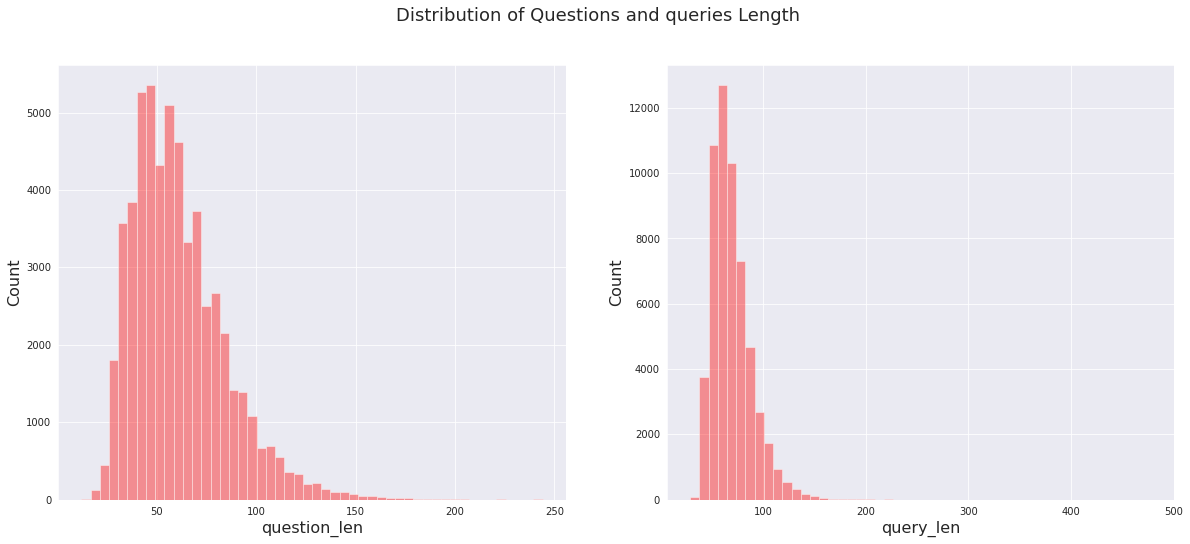

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Questions and queries Length",fontsize=18)
sns.color_palette("crest")
for i, column in enumerate(["question_len","query_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(train_df[column], kde=False, ax=axes[i], color="r", bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


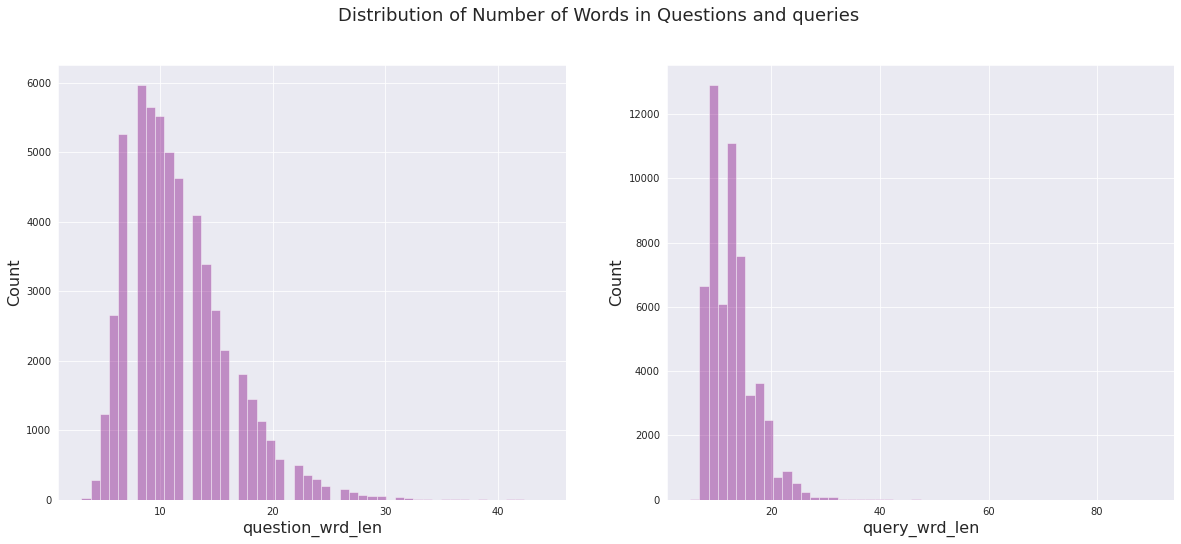

In [23]:

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Number of Words in Questions and queries",fontsize=18)

for i, column in enumerate(["question_wrd_len","query_wrd_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(train_df[column], kde=False, ax=axes[i], color="purple", bins=50)